In [1]:
import gc
import cv2
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models.segmentation import *
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp

程式撰寫大方向：

    1. 配對地匯入原始圖片與Mask
    2. 將所有圖片讀取
    3. 將所有圖片轉換成 Tensor
    3. 切割訓練、測試資料
    4. 建立 TensorDataset, DataLoader
    5. 定義模型、損失函數與優化器

程式撰寫大方向（每次訓練前再輸入圖片的版本）：

    1. 列出所有原始圖片、切片圖片的 ID
    2. 將 ID 做訓練、測試資料的切割
    3. 將訓練資料、測試資料進行 Batch
    4. 定義模型、損失函數與優化器
    5. 每個 Batch 的資料輪流取出來，進行後續的圖片讀取、圖片轉換成 Tensor、模型訓練或測試

In [9]:
# 大方向 1：列出所有原始圖片、切割圖片的 ID
zipData = zipfile.ZipFile(".//SEG_Train_Mask_Images_Dataset_20220511_Width_Height_Augumentation.zip")
zipData.extractall()

In [2]:
original_images = sorted([f"Train_images//{i}" for i in os.listdir("Train_images") if (".jpg" in i)])
mask_images = sorted([f"Train_Mask//{i}" for i in os.listdir("Train_Mask") if (".jpg" in i)])

In [3]:
original_images.__len__(), mask_images.__len__()

(6318, 6318)

In [4]:
# 大方向 2：將 ID 做訓練、測試資料的切割
xtrain_id, xtest_id, ytrain_id, ytest_id = train_test_split(original_images, mask_images, shuffle = True, test_size = 0.2)

In [5]:
# 大方向 3：將訓練資料、測試資料進行 Batch
batch_size = 2

np.random.seed(12345)
np.random.shuffle(xtrain_id)
np.random.seed(12345)
np.random.shuffle(ytrain_id)
np.random.seed(12345)
np.random.shuffle(xtest_id)
np.random.seed(12345)
np.random.shuffle(ytest_id)

train_set_group = (xtrain_id.__len__() // batch_size) + 1
test_set_group = (xtest_id.__len__() // batch_size) + 1
trainset_batch = [(xtrain_id[one_batch * batch_size: one_batch * batch_size + batch_size], ytrain_id[one_batch * batch_size: one_batch * batch_size + batch_size])
                  if one_batch + 1 != train_set_group else (xtrain_id[one_batch * batch_size: ], ytrain_id[one_batch * batch_size: ]) for one_batch in range(train_set_group)]
testset_batch = [(xtrain_id[one_batch * batch_size: one_batch * batch_size + batch_size], ytrain_id[one_batch * batch_size: one_batch * batch_size + batch_size])
                  if one_batch + 1 != train_set_group else (xtrain_id[one_batch * batch_size: ], ytrain_id[one_batch * batch_size: ]) for one_batch in range(test_set_group)]
trainset_batch = trainset_batch[:-1] if trainset_batch[-1][0].__len__() == 0 else trainset_batch
testset_batch = testset_batch[:-1] if testset_batch[-1][0].__len__() == 0 else testset_batch
# print(testset_batch)


### package 參考連結
https://smp.readthedocs.io/en/latest/encoders.html

In [6]:
# 大方向 4：定義模型、損失函數與優化器
# class segmentation_transfer_learning(nn.Module):
#     def __init__(self):
#         super(segmentation_transfer_learning, self).__init__()
#         self.model = fcn_resnet101(pretrained = True)
#         self.decoder = nn.Sequential(
#             nn.Conv2d(in_channels = 21, out_channels = 1, kernel_size = 1),
#             nn.Sigmoid()
#         )
#         return

#     def forward(self, X):
#         X = self.model(X)
#         X = self.decoder(X["out"])
#         return X

# model = segmentation_transfer_learning().cuda()
# loss_func = nn.BCEWithLogitsLoss()

model = smp.create_model(
    "fpn",
    encoder_name = "inceptionv4",
    encoder_weights = "imagenet+background",
    in_channels = 3,
    classes = 1
).cuda()
loss_func_dice = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
# loss_func_BCE = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)

In [ ]:
# 大方向 5：每個 Batch 的資料輪流取出來，進行後續的圖片讀取、圖片轉換成 Tensor、模型訓練或測試
epochs = 15
train_loss_list, test_loss_list = list(), list()
train_loss, vali_loss = 0.0, 0.0

for epoch in range(epochs):
    train_loss, vali_loss = 0.0, 0.0
    model.train()
    for original_image, mask_image in tqdm(trainset_batch, desc = f"Epoch: {epoch}, Train Model"):
        # 讀取圖片
        original_image = [cv2.resize(plt.imread(i) / 255, (1696, 928)).transpose((2, 0, 1)) for i in original_image]
        mask_image = [np.where(cv2.resize(plt.imread(i) / 255, (1696, 928)) > 0.5, 1.0, 0.0)[np.newaxis, :, :] for i in mask_image]

        # 將圖片轉換成 Tensor
        original_image = torch.cat([torch.from_numpy(i).unsqueeze(0).float() for i in original_image], axis = 0).cuda()
        mask_image = torch.cat([torch.from_numpy(i).unsqueeze(0).float() for i in mask_image], axis = 0).cuda()
                
        optimizer.zero_grad()
        yhat = model(original_image)
              
        loss = loss_func_dice(yhat, mask_image)

        train_loss += loss.cpu().item()
        loss.backward()
        optimizer.step()
        del original_image, mask_image
        gc.collect()
    scheduler.step()
    np.random.shuffle(trainset_batch)

    model.eval()
    for original_image, mask_image in tqdm(testset_batch, f"Epoch: {epoch}, Test Model"):
        # 讀取圖片
        original_image = [cv2.resize(plt.imread(i) / 255, (1696, 928)).transpose((2, 0, 1)) for i in original_image]
        mask_image = [np.where(cv2.resize(plt.imread(i) / 255, (1696, 928)) > 0.5, 1.0, 0.0)[np.newaxis, :, :] for i in mask_image]

        # 將圖片轉換成 Tensor
        original_image = torch.cat([torch.from_numpy(i).unsqueeze(0).float() for i in original_image], axis = 0).cuda()
        mask_image = torch.cat([torch.from_numpy(i).unsqueeze(0).float() for i in mask_image], axis = 0).cuda()

        with torch.no_grad():
            yhat = model(original_image)

        loss = loss_func_dice(yhat, mask_image)

        vali_loss += loss.cpu().item()
        
        del original_image, mask_image
        gc.collect()
    train_loss_list.append(train_loss / train_set_group)
    test_loss_list.append(vali_loss / test_set_group)
    print(f"Epoch: {epoch}, Train Loss: {train_loss_list[-1]}, Validation Loss: {test_loss_list[-1]}")
    torch.save(model, "Model//segmentation_fpn_inceptionv4_928_1696_20220524_Augumentation.pth")
print(train_loss_list)
print(test_loss_list)

Epoch: 0, Test Model: 100%|██████████| 633/633 [04:22<00:00,  2.42it/s]


Epoch: 0, Train Loss: 0.7064861447986546, Validation Loss: 0.6355106693120176


Epoch: 1, Train Model:  63%|██████▎   | 1595/2527 [24:54<14:16,  1.09it/s]

In [7]:
# FCN resnet50 with BCELoss
# print(train_loss_list)
# print(test_loss_list)

[0.009620583098121341, 0.001157896667696818, 0.000790674310846263, 0.0006725550659888609, 0.0006120774698881234]
[0.0016411609139363721, 0.0008732895756729018, 0.0006999968544784318, 0.0006196890204797833, 0.0005748977457427964]


In [7]:
# deeplabv3_resnet50 with BCELoss
# print(train_loss_list)
# print(test_loss_list)

[0.12050220042784915, 0.011119584323423451, 0.004727395139391848, 0.00262735919890069, 0.001848432403697822]
[0.03915682117199912, 0.014456862662831005, 0.02497368155570068, 0.04102191005785124, 0.09586824317251877]


In [10]:
# deeplabv3_resnet50 with BCEwithLogitLoss
# print(train_loss_list)
# print(test_loss_list)

[0.6954078850870449, 0.6915442121537376, 0.6915189174679218, 0.6915211601279924, 0.6915131640660255, 0.691508743011556, 0.6915074113703452, 0.6915067968210338]
[0.6932583856132796, 0.6931977069602823, 0.6931716659159031, 0.6932690846470168, 0.6931680030417893, 0.6931625312229373, 0.6931584201893717, 0.6931553314316947]


In [76]:
# Unet_resnet101 with DiceLoss
# print(train_loss_list)
# print(test_loss_list)

[0.6682336218831664, 0.5221752165618101, 0.49800805076603644, 0.48438418123394394, 0.4607145126679497, 0.44388447483003984, 0.4297175410234533, 0.42378542505169364, 0.41136290987520985, 0.4097987379507996, 0.3935015595637227, 0.3859656650873157, 0.37530573411575424, 0.3687919217263353, 0.3534869586969439, 0.35289061479093903, 0.3475423304108082, 0.34545801530517106, 0.33110978041214967, 0.32557134718691566]
[0.731915756216589, 0.6109885708341058, 0.7710641768743407, 0.6128736352020839, 0.5910239388357919, 0.5982389056457663, 0.6241457018087495, 0.6296941013831012, 0.5907708237755973, 0.610545500269476, 0.5844019561443689, 0.5602404345881264, 0.5881059203507766, 0.512427215306264, 0.5239953983504817, 0.5409002540246496, 0.5054943061099862, 0.49386523017343487, 0.5061414837837219, 0.4720792275554729]


[0.5781238495738585, 0.539699738907023, 0.4908359111485323, 0.47641468994425373, 0.48725444304434606, 0.45996036023890235, 0.42098081620383604, 0.40515249515596724, 0.39233400951629566, 0.3832817762666404, 0.3703333065973074, 0.35468784525496133, 0.35106633991991737, 0.34005249337562454, 0.33099084117966243, 0.32029304572191286, 0.3126641619261972, 0.30500477029813977, 0.29495638933791934, 0.2914265648448637]
[0.8200019997245861, 0.6162003886024907, 0.6890217071434237, 0.6129230660087658, 0.604267697289305, 0.5812230948007332, 0.7140070739782082, 0.5349328754083166, 0.5771108725160923, 0.6045383563581502, 0.6077777681485662, 0.5239526050270729, 0.5616886992499514, 0.5302024641126957, 0.45602719120259555, 0.5124266209467402, 0.45466319963617147, 0.4540218975184099, 0.4789271422152249, 0.4576691321606906]


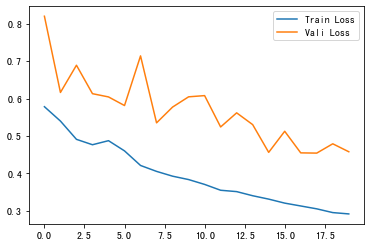

In [87]:
# Unet_resnext101_32x8d with DiceLoss
# print(train_loss_list)
# print(test_loss_list)
# plt.plot(train_loss_list, label = "Train Loss")
# plt.plot(test_loss_list, label = "Vali Loss")
# plt.legend()
# plt.show()

[0.6316001670902939, 0.5116901916067748, 0.4792516748487102, 0.45670038052079803, 0.4397011714241516, 0.42242811330686814, 0.40840655706505075, 0.40491290129191504, 0.38440189274001463, 0.37403782820814596, 0.35570814456984895, 0.34443705737308306, 0.335821724757199, 0.32271387339768254, 0.31116580341664535, 0.29972518860446334, 0.29980118904633546, 0.27951089268047097, 0.2721582782494513, 0.2578409003420464, 0.2506531930365269, 0.2446011472934795, 0.23688778916806405, 0.23011710688966144, 0.22053576772811853]
[0.7420295364451859, 0.6443205756961174, 0.5923572435693921, 0.6282560234924532, 0.6410024261699533, 0.560815082406098, 0.6548584395984434, 0.510056678978902, 0.5792081828387279, 0.5687526964916373, 0.5410940197278868, 0.5078085868988397, 0.6138413902723564, 0.5316645834805831, 0.45569573820761916, 0.6735778591542874, 0.42555717983335817, 0.5375468730926514, 0.4793584864094572, 0.5888376590215935, 0.41830722284766864, 0.4122862073610414, 0.432686393553356, 0.37243465713734897, 0.

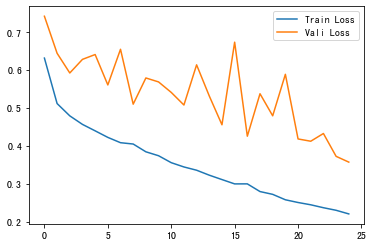

In [121]:
# Unet_dpn68 with DiceLoss
# print(train_loss_list)
# print(test_loss_list)
# plt.plot(train_loss_list, label = "Train Loss")
# plt.plot(test_loss_list, label = "Vali Loss")
# plt.legend()
# plt.show()

[0.6769438387375872, 0.5325101205805467, 0.5009570529958083, 0.4759643986044337, 0.44762484679854875, 0.4306301697735538, 0.42266969898300716, 0.4066340902122841, 0.37981148720917546, 0.37056356724969586, 0.35279861134940416, 0.3371152004924431, 0.3227263910793015, 0.3082420544884216, 0.28349956559343925]
[0.6428024437067643, 0.5948254038702767, 0.5561342149410607, 0.5386564079320656, 0.5537271319695238, 0.48089600115452175, 0.47796970099773045, 0.5907781377153577, 0.6248482859359598, 0.60992428041854, 0.5010230130744431, 0.6725394905738111, 0.5104581303191635, 0.5573208416407963, 0.38600182027186986]


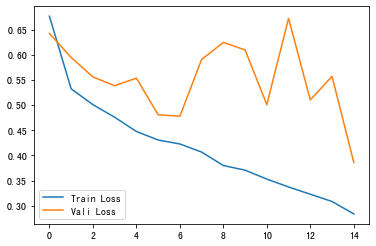

In [145]:
# Unet_vgg16 with DiceLoss
# print(train_loss_list)
# print(test_loss_list)
# plt.plot(train_loss_list, label = "Train Loss")
# plt.plot(test_loss_list, label = "Vali Loss")
# plt.legend()
# plt.show()

[0.4818122207553466, 0.2858388308100226, 0.24396439214453314, 0.21185769712755465, 0.18381150596514698, 0.15110374612830826, 0.15352728934649607, 0.1490768793069921]
[0.4122649712382622, 0.22213029524065414, 0.26455314035685557, 0.2022764744623652, 0.17624244150125756, 0.17118114064324577, 0.17400258442140976, 0.13580096555206012]


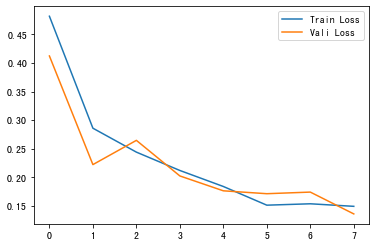

In [7]:
# Unet_xception_928_1696 with DiceLoss
# print(train_loss_list)
# print(test_loss_list)
# plt.plot(train_loss_list, label = "Train Loss")
# plt.plot(test_loss_list, label = "Vali Loss")
# plt.legend()
# plt.show()

[0.6096926820221671, 0.49100849512629036, 0.4846212026349741, 0.4628384925460363, 0.4536628249979697, 0.4319390928575778, 0.4102090626813789, 0.3796039017455838, 0.37369789317320873, 0.3549849895221927]
[0.6260868608951569, 0.5901513504532149, 0.6191934667668253, 0.6288252068015764, 0.5948492367312593, 0.6032950585743166, 0.4431092210535733, 0.5063524521746725, 0.4824651299782519, 0.41609123180497365]


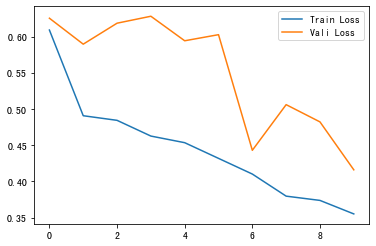

In [7]:
# # Unet_resnet50_928_1696 with DiceLoss
# print(train_loss_list)
# print(test_loss_list)
# plt.plot(train_loss_list, label = "Train Loss")
# plt.plot(test_loss_list, label = "Vali Loss")
# plt.legend()
# plt.show()

[0.6658231569409936, 0.30348442798542186, 0.25085015573772773, 0.2145850483275138, 0.18253427037695572, 0.15198538131058498, 0.12369724868033169, 0.11740850102844962, 0.10051267887178755, 0.08830772163743657]
[0.44003718023030264, 0.27203368240932246, 0.28918267533464254, 0.21331529853478917, 0.16503400229058177, 0.14507131250399463, 0.13035404119851454, 0.1268363431939539, 0.12421929049042035, 0.11071695415478833]


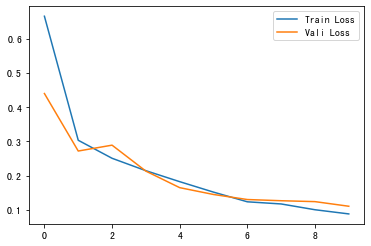

In [8]:
# # FPN_Xception_928_1696 with DiceLoss
# print(train_loss_list)
# print(test_loss_list)
# plt.plot(train_loss_list, label = "Train Loss")
# plt.plot(test_loss_list, label = "Vali Loss")
# plt.legend()
# plt.show()

[0.3421315551275694, 0.2500217303963779, 0.2124205492201108, 0.18145493003009242, 0.15806095608616177, 0.14107768081977398, 0.12158176097783106, 0.11490307946371127, 0.1042617826097751, 0.09469270805203461]
[0.3979614809226086, 0.27535596456949557, 0.23802636293061724, 0.2157096472020021, 0.19987370203268284, 0.19781943510682284, 0.1589850968847531, 0.17098476216314717, 0.1308760930199947, 0.11556233143166154]


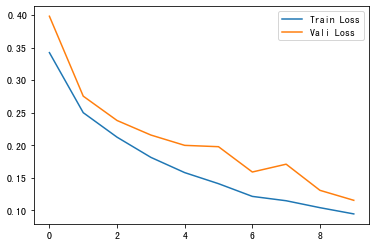

In [12]:
# # FPN_Xception_928_1696 with DiceLoss and Augumentation
# print(train_loss_list)
# print(test_loss_list)
# plt.plot(train_loss_list, label = "Train Loss")
# plt.plot(test_loss_list, label = "Vali Loss")
# plt.legend()
# plt.show()

[0.46114861005563523, 0.35537327177633965, 0.30800746489740627, 0.2898216434058887, 0.2615858768171902, 0.23711854610827904, 0.21938257961522176, 0.21034220485841926, 0.19213519417503966, 0.17996936114622822]
[0.46354482957348814, 0.44856159655027106, 0.4146172982444884, 0.4069511787774627, 0.339212203948607, 0.3093941949931743, 0.2759048325755585, 0.2786480890819435, 0.2557004887910816, 0.26558157853417297]


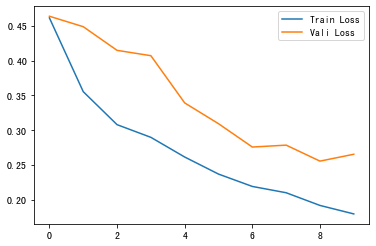

In [8]:
# Unet_InceptionV4_928_1696 with DiceLoss and Augumentation
# print(train_loss_list)
# print(test_loss_list)
# plt.plot(train_loss_list, label = "Train Loss")
# plt.plot(test_loss_list, label = "Vali Loss")
# plt.legend()
# plt.show()

[0.37101284091514125, 0.26284749487627157, 0.20196999661341497, 0.17929784441956237, 0.15709030482022068, 0.14534156003236015, 0.12260355670712417, 0.11612110667496542, 0.10495182197493842, 0.09788975819851024]
[0.3206342826899006, 0.2967095023836193, 0.3277307656515643, 0.20419495968268758, 0.1670191970670016, 0.149770805526872, 0.15411391538842972, 0.14437954120726382, 0.12168038955420303, 0.12051329087307103]


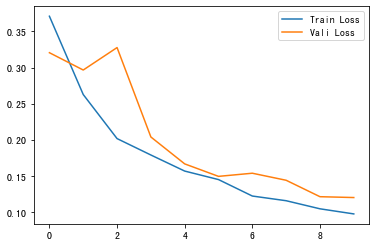

In [11]:
# # Unet_Xception_928_1696 with DiceLoss and Augumentation, scse
# print(train_loss_list)
# print(test_loss_list)
# plt.plot(train_loss_list, label = "Train Loss")
# plt.plot(test_loss_list, label = "Vali Loss")
# plt.legend()
# plt.show()

[0.8702519118892676, 0.8294724544850729, 0.7890528376384448, 0.7752888557838282, 0.7664125702180316, 0.7543194240032558, 0.7504790490459797, 0.7385354389746984, 0.7306418777793966, 0.7209659076185637]
[0.8562850996851921, 0.7967220568231174, 0.7937564896685737, 0.7860083422490529, 0.764211791753769, 0.7595046315874372, 0.7493332096508571, 0.7561454800622803, 0.7474290647677013, 0.7633265009948186]


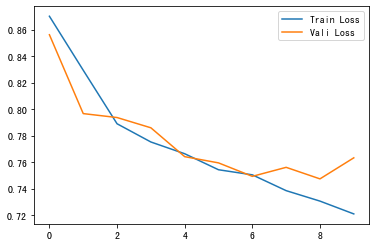

In [29]:
# # Unet_Xception_928_1696 with DiceLoss and Augumentation, scse, Mixout
# print(train_loss_list)
# print(test_loss_list)
# plt.plot(train_loss_list, label = "Train Loss")
# plt.plot(test_loss_list, label = "Vali Loss")
# plt.legend()
# plt.show()

[0.9299971578382951, 0.8799761222802567, 0.8291163437444308, 0.8158932484222096, 0.8063140810066586, 0.8011486435856239, 0.7940852441844317, 0.7869108322466163, 0.783045570432963, 0.7811452362940644]
[0.9111618391145462, 0.8589767627241487, 0.8371883923126058, 0.81802006524886, 0.8223858793482396, 0.80982985767708, 0.801819678025223, 0.8107004609153169, 0.7976957977665544, 0.7940459502816766]


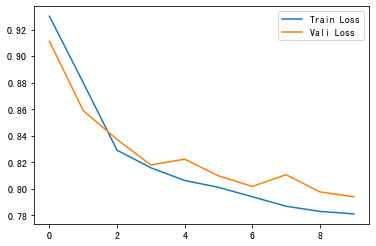

In [16]:
# # PAN_resnet50_928_1696 with DiceLoss and Augumentation, scse, Mixout
# print(train_loss_list)
# print(test_loss_list)
# plt.plot(train_loss_list, label = "Train Loss")
# plt.plot(test_loss_list, label = "Vali Loss")
# plt.legend()
# plt.show()

[0.8286521879431048, 0.7872500903882329, 0.7772389321369658, 0.7631214931386161, 0.7554384311158154, 0.741775037308475, 0.7312154096028926, 0.7193176609826017, 0.7042044860319143, 0.6911733836377764]
[0.8586161203011518, 0.7982317154158913, 0.8014912520539704, 0.7843074018921332, 0.7714906478945113, 0.7516301666955812, 0.7462530670007823, 0.736871333483836, 0.7386498557165335, 0.7285568749452654]


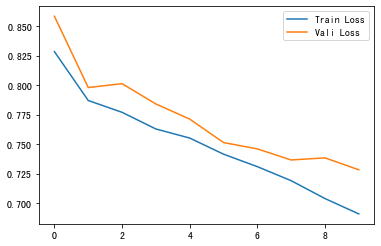

In [9]:
# # MAnet_xception_928_1696 with DiceLoss and Augumentation, scse
# print(train_loss_list)
# print(test_loss_list)
# plt.plot(train_loss_list, label = "Train Loss")
# plt.plot(test_loss_list, label = "Vali Loss")
# plt.legend()
# plt.show()

[0.3777841632313366, 0.28191728882868833, 0.24475808370905586, 0.22147401535435568, 0.18880510931433755, 0.18106002881651437, 0.16741376563529425, 0.14613531183309947, 0.14402288776126843, 0.13476216168248956]
[0.37263474654624057, 0.4507492167689789, 0.28332972677209745, 0.28709104548886677, 0.235542358757007, 0.3293662360305846, 0.29483765439022963, 0.19881604774303346, 0.1904222505729157, 0.17115755828824278]


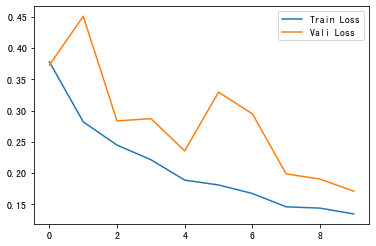

In [8]:
# # UnetPlusPlus_xception_928_1696 with DiceLoss and Augumentation, scse
# print(train_loss_list)
# print(test_loss_list)
# plt.plot(train_loss_list, label = "Train Loss")
# plt.plot(test_loss_list, label = "Vali Loss")
# plt.legend()
# plt.show()

[0.38208114749551575, 0.2778352386777914, 0.23328397918162466, 0.24200659379645995, 0.20193030015577243, 0.17407563460778586, 0.159307400872813, 0.15112481780255896, 0.13972072555577453, 0.12263130080662196]
[0.40537696201089435, 0.3229251413548727, 0.2672507230892754, 0.37706791610702706, 0.23569794505316688, 0.2515267601698684, 0.2078404129022294, 0.19135696053693269, 0.1908169479166727, 0.17536731127879066]


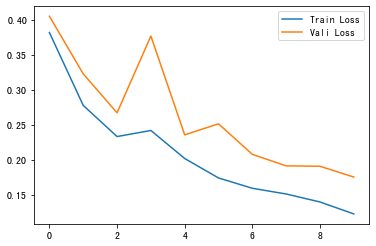

In [8]:
# # MAnet_xception_928_1696 with DiceLoss and Augumentation, scse
# print(train_loss_list)
# print(test_loss_list)
# plt.plot(train_loss_list, label = "Train Loss")
# plt.plot(test_loss_list, label = "Vali Loss")
# plt.legend()
# plt.show()

[0.6146149955265507, 0.5443238056960362, 0.5305452024257635, 0.5437090463370462, 0.5319792152724311, 0.5616154661991551, 0.5286385332340304, 0.5219440468693082, 0.49145372341610966, 0.4881289856437641, 0.4442861344240889, 0.45911629299951506, 0.45521282838492455, 0.5066332681976919, 0.46490412287979943]
[0.8960551579039997, 0.7312116270758341, 0.8484606936832928, 0.668432700125527, 0.6497210743491307, 0.6936549920041414, 0.6818382185405653, 0.6667341501415247, 0.6757848884257095, 0.6847577330437128, 0.6619368155044025, 0.6046870131439884, 0.6507254307868922, 0.6620616906250446, 0.6738322354605978]


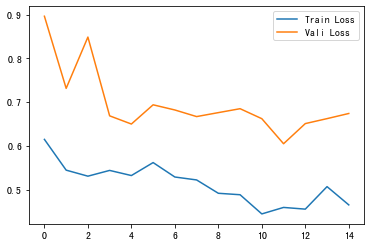

In [14]:
# # PAN_dpn92_928_1696 with DiceLoss and Augumentation, scse
# print(train_loss_list)
# print(test_loss_list)
# plt.plot(train_loss_list, label = "Train Loss")
# plt.plot(test_loss_list, label = "Vali Loss")
# plt.legend()
# plt.show()

[0.47991778515279293, 0.3930865774001879, 0.33521129775650893, 0.29177539133101327, 0.2671964461148917, 0.2453316782330033, 0.22432353347539902, 0.21065670334368566, 0.196771526261221, 0.18420209042445013, 0.17274551095936116, 0.1633316012028652, 0.15309323198338853, 0.1455076227931282, 0.1364860484447283]
[0.542716131673605, 0.4091025506150666, 0.3669827916610862, 0.3168331677503119, 0.32118841219475674, 0.286541323714535, 0.24242932884990698, 0.2336551733491545, 0.2303139278297364, 0.2035265922734711, 0.20492206987046518, 0.21249362049509563, 0.19518153635434818, 0.1731569141761575, 0.17965314700893503]


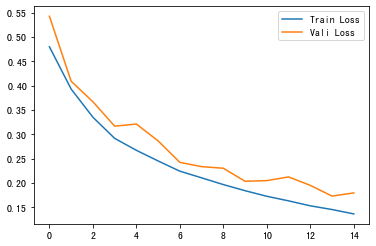

In [9]:
# fpn_se_resnet50_928_1696 with DiceLoss and Augumentation, scse
print(train_loss_list)
print(test_loss_list)
plt.plot(train_loss_list, label = "Train Loss")
plt.plot(test_loss_list, label = "Vali Loss")
plt.legend()
plt.show()

[0.9827778869650409, 0.9630079244652504, 0.9707828939102495, 0.9946247331939543, 0.9575269326944894, 0.9540965230074487, 0.9591319501824394, 0.9608591393437944, 0.9613105489907763, 0.9613378626777779, 0.9613243627208697, 0.9614184113054336, 0.9614336286211693, 0.9612813411115468, 0.9613395045169547]
[0.9604106161266707, 0.9578773038458862, 0.9960136732783927, 0.9956780475274458, 0.9508763666589867, 0.9555956988726371, 0.9582615489078359, 0.9597909244315884, 0.9604462375761397, 0.9599086903094493, 0.9605486023859202, 0.960011127718252, 0.9600286638190584, 0.9600095492780303, 0.9600835522580863]


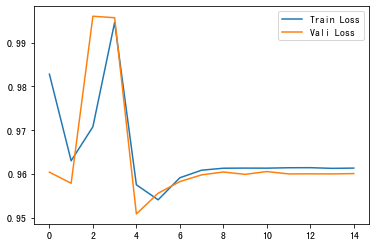

In [10]:
# fpn_VGG19_928_1696 with DiceLoss and Augumentation, scse
print(train_loss_list)
print(test_loss_list)
plt.plot(train_loss_list, label = "Train Loss")
plt.plot(test_loss_list, label = "Vali Loss")
plt.legend()
plt.show()

[0.7064861447986546, 0.46049060061856917, 0.3881125030213896, 0.3329312707757271, 0.29953790366461003, 0.2784617829690628, 0.25918999071456966, 0.23807531074161017, 0.22475252731974366, 0.217324369386593, 0.19867406707681431, 0.18824999107495893, 0.17881643095442765, 0.16849384838833084, 0.15934710197527951]
[0.6355106693120176, 0.5409448773940028, 0.4671508201867295, 0.42988052140291644, 0.38933709758152896, 0.39014671246210736, 0.3290509447855595, 0.34134452744117844, 0.32460578857063305, 0.3046838889754779, 0.3183300606259049, 0.30506195323350493, 0.2669806035962338, 0.2565395721892045, 0.2667220079503353]


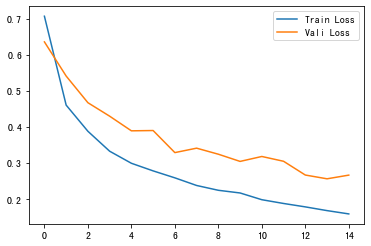

In [8]:
# fpn_inceptionV4_928_1696 with DiceLoss and Augumentation, scse
print(train_loss_list)
print(test_loss_list)
plt.plot(train_loss_list, label = "Train Loss")
plt.plot(test_loss_list, label = "Vali Loss")
plt.legend()
plt.show()

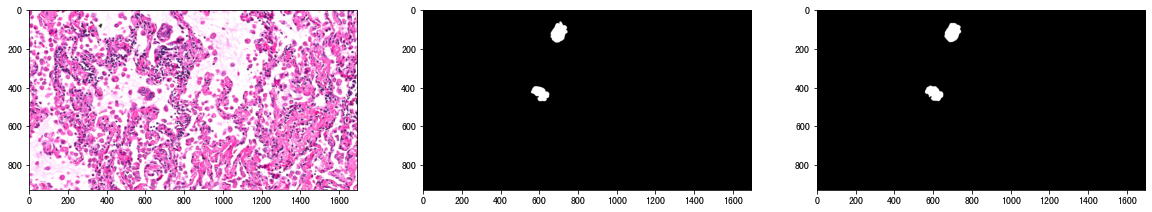

In [14]:
plt.figure(figsize = (20, 10))
plt.subplot(1, 3, 1)
plt.imshow(original_image[1, :, :, :].cpu().detach().numpy().transpose((1, 2, 0)))
plt.subplot(1, 3, 2)
plt.imshow(torch.where(mask_image[1, 0, :, :].sigmoid().cpu() * 255 > 150, 255, 0).detach().numpy(), cmap = "gray")
plt.subplot(1, 3, 3)
plt.imshow(torch.where(yhat[1, 0, :, :].sigmoid().cpu() * 255 > 150, 255, 0).detach().numpy(), cmap = "gray")
plt.show()